<a href="https://www.kaggle.com/code/nazimcherpanov/spaceship-titanic-beginner-friendly-tutorial?scriptVersionId=125670565" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


## 1. **Importing Dataset**

In [2]:
# Load training data
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

# Load test data
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# Load sample submission data
sample = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [3]:
# Display the first 5 rows of the training dataset to inspect the data
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Call the describe method on the train dataset to get a summary of its numerical variables.
# The T method transposes the output to display the summary statistics horizontally instead of vertically.
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


## 2. **Data cleaning and Data transformation**

In [5]:
# Calculate the proportion of missing values in each column of the train DataFrame
train.isna().mean()

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

In [6]:
# Multiply the 'Transported' column of the 'train' DataFrame by 1
# This is a common trick used to convert boolean values to 1 and 0, since 
# True * 1 = 1 and False * 1 = 0
train['Transported'] = train['Transported']*1

In [7]:
# Count the number of occurrences of each unique value in the 'HomePlanet' column of the 'train' DataFrame
train['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [8]:
# Count the number of occurrences of each unique value in the 'Destination' column of the 'train' DataFrame
train['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [9]:
def clean(df):
    # Set up imputer and label encoder
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    le = LabelEncoder()
    
    # Convert CryoSleep column to int
    df['CryoSleep'] = df['CryoSleep']*1
    
    # Split Cabin column into Deck, Cabin_num, and Side columns
    df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
    
    # Impute missing values in certain columns
    df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CryoSleep', 'Cabin_num']] = imputer.fit_transform(df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CryoSleep', 'Cabin_num']])
    
    # Replace missing values in certain columns with specified values
    vals, nls = ['HomePlanet', 'Destination', 'Deck', 'Side'], ['Earth', 'TRAPPIST-1e', 'F', 'P']
    for i in range(len(vals)):
        df[vals[i]].fillna(nls[i], inplace=True)
    
    # Encode certain columns using label encoder
    for j in ['HomePlanet', 'Destination', 'Deck', 'Side']:    
        df[j] = le.fit_transform(df[j].astype(str))
    
    # Return cleaned dataframe
    return df

In [10]:
# Clean the training data using the clean function
train = clean(train)

In [11]:
# Calculate the proportion of missing values in each column of the train DataFrame
train.isna().mean()

PassengerId     0.000000
HomePlanet      0.000000
CryoSleep       0.000000
Cabin           0.022892
Destination     0.000000
Age             0.000000
VIP             0.023352
RoomService     0.000000
FoodCourt       0.000000
ShoppingMall    0.000000
Spa             0.000000
VRDeck          0.000000
Name            0.023007
Transported     0.000000
Deck            0.000000
Cabin_num       0.000000
Side            0.000000
dtype: float64

In [12]:
# Display the data types of each column in the train dataframe
train.dtypes

PassengerId      object
HomePlanet        int64
CryoSleep       float64
Cabin            object
Destination       int64
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
Deck              int64
Cabin_num       float64
Side              int64
dtype: object

In [13]:
# Count the number of occurrences of each unique value in the 'HomePlanet' column of the 'train' DataFrame
train['HomePlanet'].value_counts()

0    4803
1    2131
2    1759
Name: HomePlanet, dtype: int64

In [14]:
# Count the number of occurrences of each unique value in the 'Destination' column of the 'train' DataFrame
train['Destination'].value_counts()

2    6097
0    1800
1     796
Name: Destination, dtype: int64

## 3. **Data Analysis and Vizualization**

* **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* **Destination** - The planet the passenger will be debarking to.
* **Age** - The age of the passenger.
* **VIP** - Whether the passenger has paid for special VIP service during the voyage.
* **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* **Name** - The first and last names of the passenger.
* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [15]:
# Create a new column called 'groupN' in the 'train' DataFrame
# The values in this column will be calculated based on the 'PassengerId' column
train['groupN'] = [
    int(i.split('_')[0])  # Extract the first part of the string in 'PassengerId', which represents the group number
    for i in train['PassengerId']  # For each value in the 'PassengerId' column
]

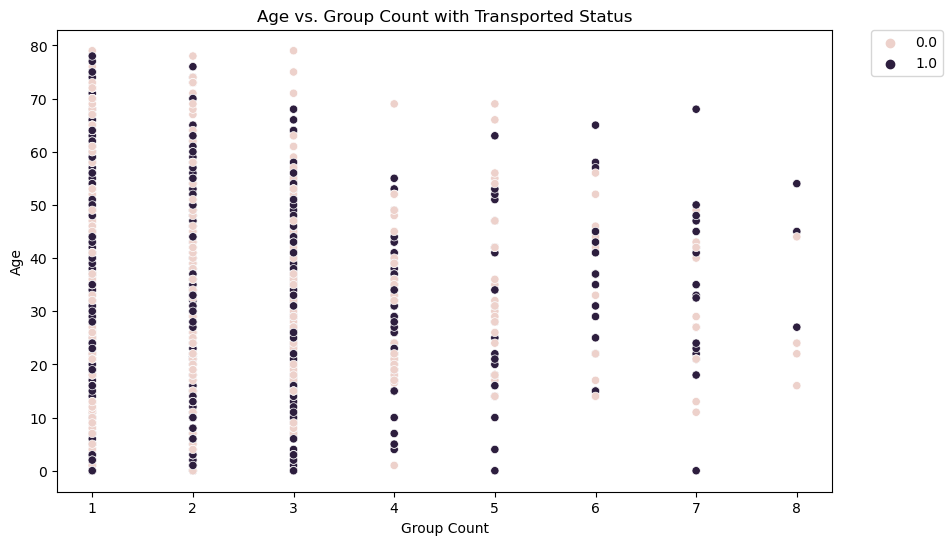

In [16]:
# Count the number of occurrences of each unique value in the 'groupN' column
x = train['groupN'].value_counts()

# Select the 'Age' column
y = train['Age']

# Select the 'Transported' column to use for hue
hue = train['Transported']

# Create a figure and axis object with a specified size
fig, ax = plt.subplots(figsize=(10, 6))

# Create a scatter plot with x and y as the coordinates, using hue for color coding
sns.scatterplot(x=x, y=y, hue=hue, ax=ax)

# Set the x-axis label
ax.set_xlabel('Group Count')

# Set the y-axis label
ax.set_ylabel('Age')

# Set the plot title
ax.set_title('Age vs. Group Count with Transported Status')

# Add a legend to the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Display the plot
plt.show()

#### **I can't see any correlation between the number of people in a group and other variables.**

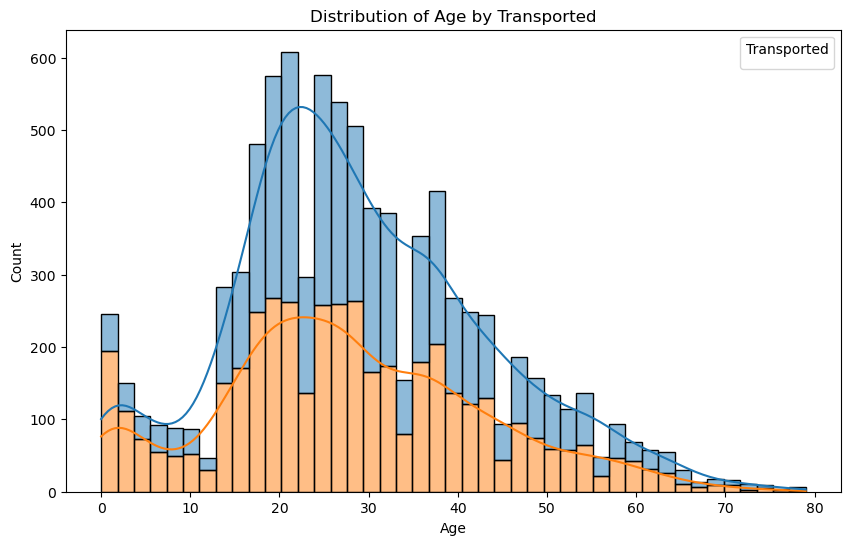

In [17]:
# Create a figure and axis with a size of 10x6
fig, ax = plt.subplots(figsize=(10, 6))

# Create a stacked histogram with the Age column on the x-axis and Transported column as the hue
# Use KDE (Kernel Density Estimation) to estimate the distribution of each group and display the result as a curve
sns.histplot(x=train['Age'], hue=train['Transported'], ax=ax, kde=True, multiple="stack")

# Set the x-label to "Age"
ax.set_xlabel("Age")
# Set the y-label to "Count"
ax.set_ylabel("Count")
# Set the title to "Distribution of Age by Transported"
ax.set_title("Distribution of Age by Transported")

# Get the legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# Set the legend title to "Transported" and place it in the upper right corner
ax.legend(handles, labels, title="Transported", loc="upper right")

# Display the plot
plt.show()

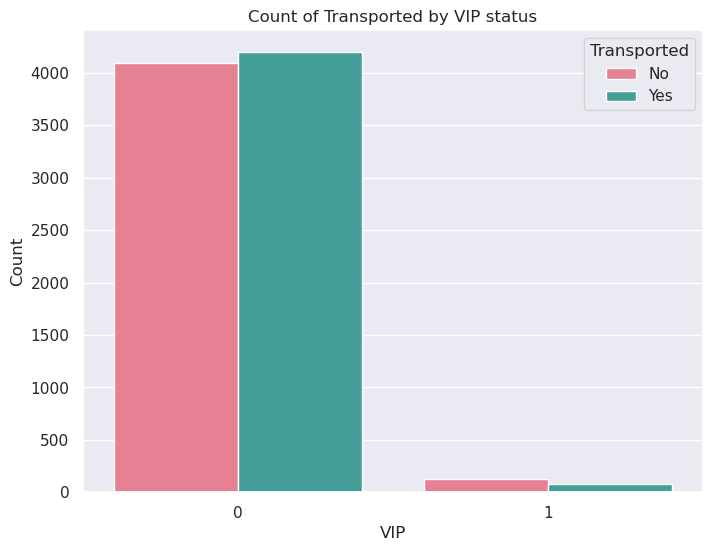

In [18]:
# Multiply the 'VIP' column in the 'train' DataFrame by 1, which converts it to a numerical column
train['VIP'] = train['VIP']*1

# Set the style of the seaborn plots to 'darkgrid'
sns.set(style='darkgrid')

# Create a new figure with a size of 8x6 inches
plt.figure(figsize=(8, 6)) 

# Create a countplot using the 'train' DataFrame, with 'VIP' on the x-axis and 'Transported' on the hue axis,
# and use the 'husl' color palette
sns.countplot(data=train, x='VIP', hue='Transported', palette='husl')

# Set the x-axis label to 'VIP'
plt.xlabel('VIP')

# Set the y-axis label to 'Count'
plt.ylabel('Count')

# Set the title of the plot to 'Count of Transported by VIP status'
plt.title('Count of Transported by VIP status')

# Add a legend to the plot with the title 'Transported', location 'upper right', and labels 'No' and 'Yes'
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])

# Display the plot
plt.show()

In [19]:
# This code calculates the proportion of rows in the 'train' DataFrame
# where the 'VIP' column is equal to 1.
# It does this by first creating a Boolean array of True/False values,
# where True indicates that the corresponding row has VIP=1.
# Then, it takes the mean of this Boolean array, which is equal to the
# proportion of True values, or the proportion of rows where VIP=1.
(train['VIP'] == 1).mean()

0.02289198205452663

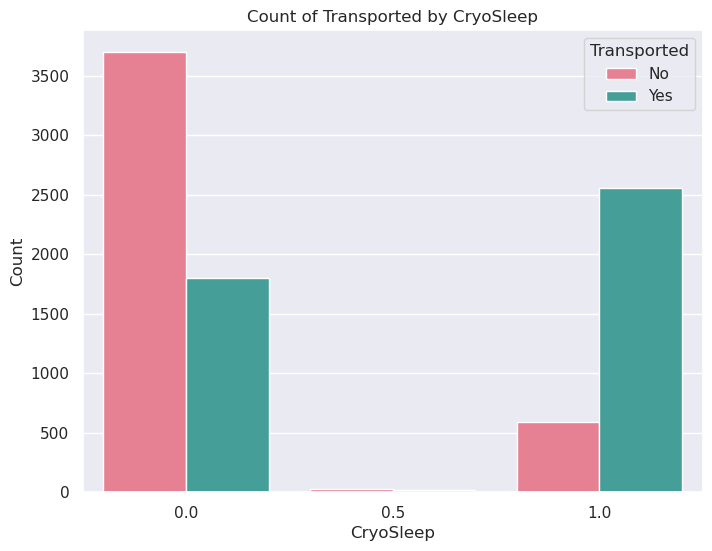

In [20]:
# Set figure size
plt.figure(figsize=(8, 6))

# Create count plot of CryoSleep with Transported as hue
sns.countplot(data=train, x='CryoSleep', hue='Transported', palette='husl')

# Set x and y labels
plt.xlabel('CryoSleep')
plt.ylabel('Count')

# Set plot title
plt.title('Count of Transported by CryoSleep')

# Add legend to plot
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])

# Show plot
plt.show()

<AxesSubplot:xlabel='Destination'>

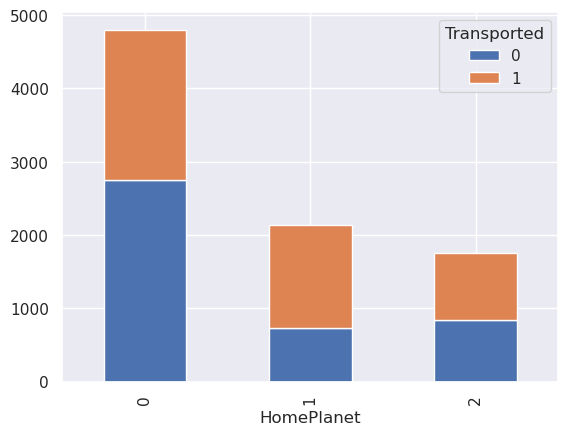

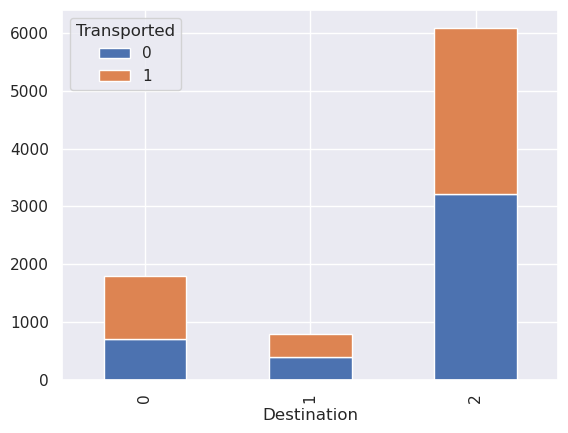

In [21]:
# Create a crosstab of the number of transported individuals from each home planet
transported_by_homeplanet = pd.crosstab(index=train['HomePlanet'], columns=train['Transported'])

# Create a crosstab of the number of transported individuals to each destination
transported_by_destination = pd.crosstab(index=train['Destination'], columns=train['Transported'])

# Plot a stacked bar chart of the number of transported individuals from each home planet
transported_by_homeplanet.plot(kind='bar', stacked=True)

# Plot a stacked bar chart of the number of transported individuals to each destination
transported_by_destination.plot(kind='bar', stacked=True)

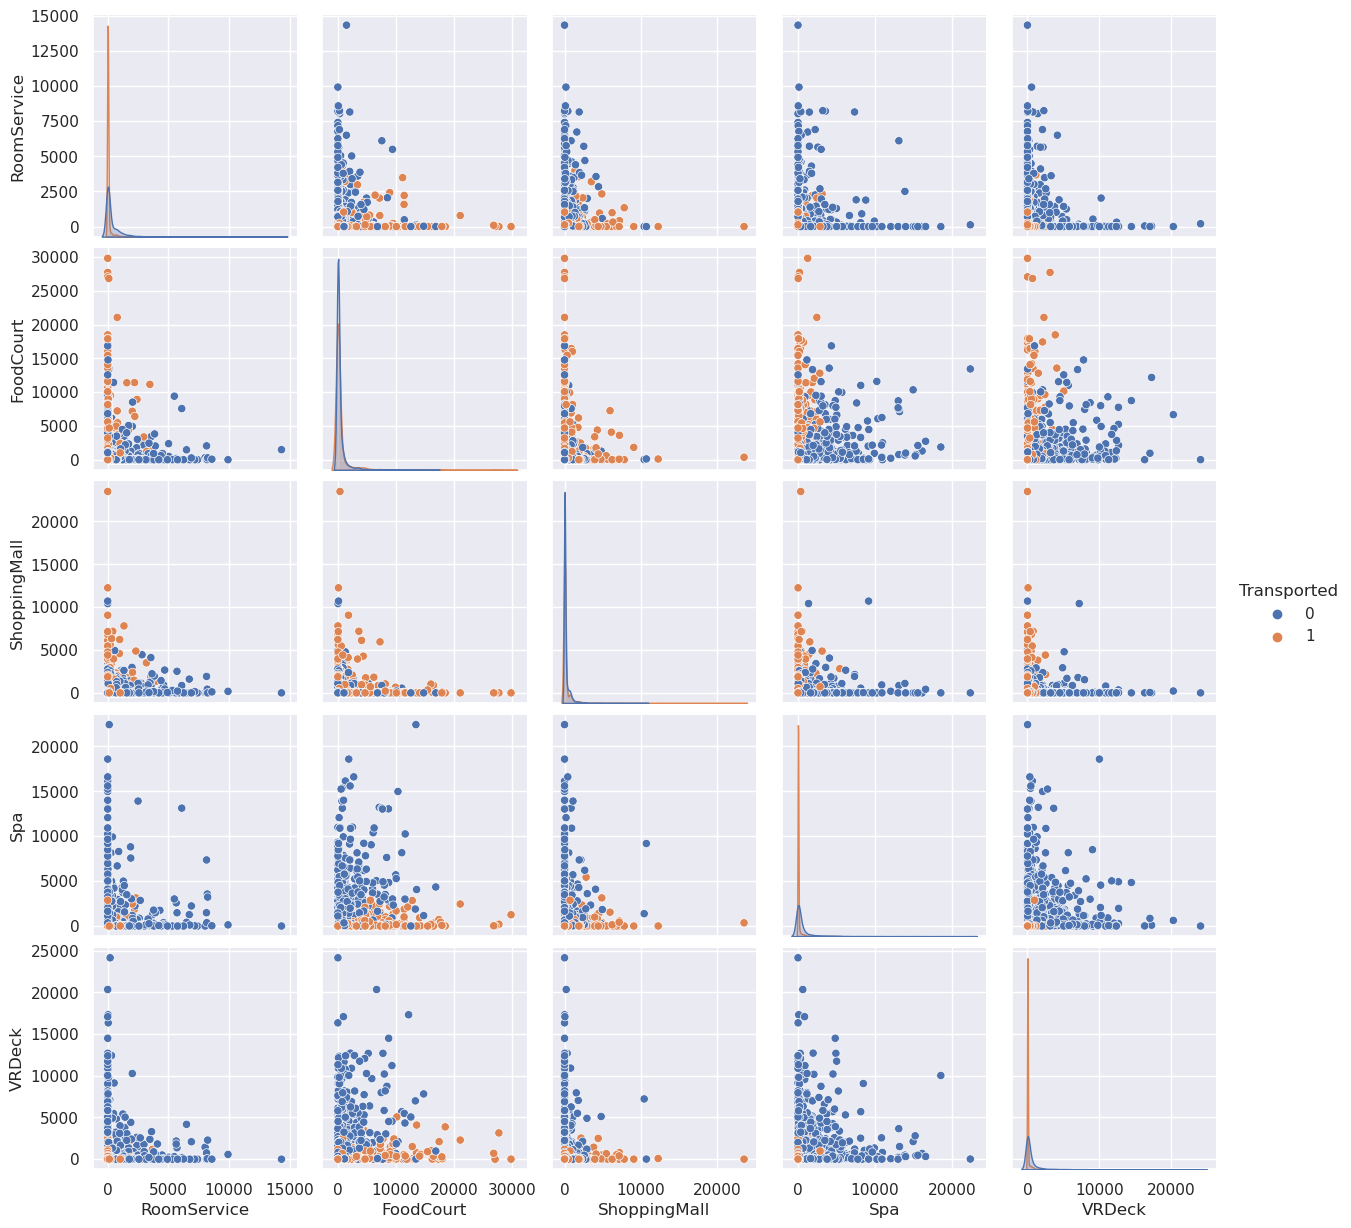

In [22]:
# Plot pairwise relationships between selected features
sns.pairplot(train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']], 
             hue='Transported')
             
# 'hue' parameter specifies the column in the dataset that determines the color of the points
# In this case, the points will be colored according to the 'Transported' column, which indicates 
# whether or not a person was transported to the vacation location via a special mode of transport. 
# The pairplot will show the pairwise relationships between the selected features, with different 
# colors indicating whether or not a person was transported.

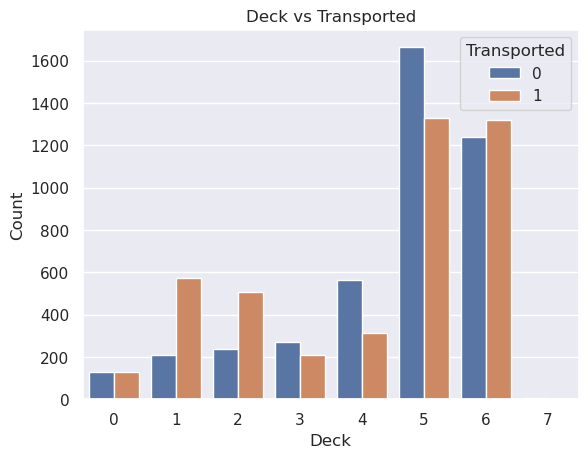

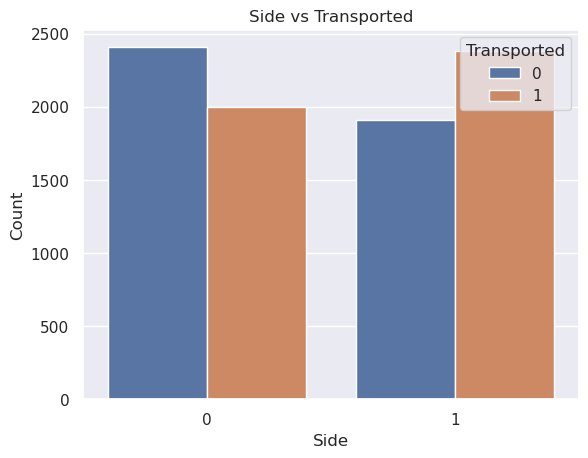

In [23]:
# Iterate over two features: 'Deck' and 'Side'
for i in ['Deck', 'Side']:
    # Create countplot using Seaborn, with 'Transported' as hue
    sns.countplot(x=i, hue='Transported', data=train)
    
    # Add title to plot with the feature name and 'vs Transported'
    plt.title(f'{i} vs Transported')
    
    # Label x-axis with the feature name
    plt.xlabel(i)
    
    # Label y-axis with 'Count'
    plt.ylabel('Count')
    
    # Display the plot
    plt.show()

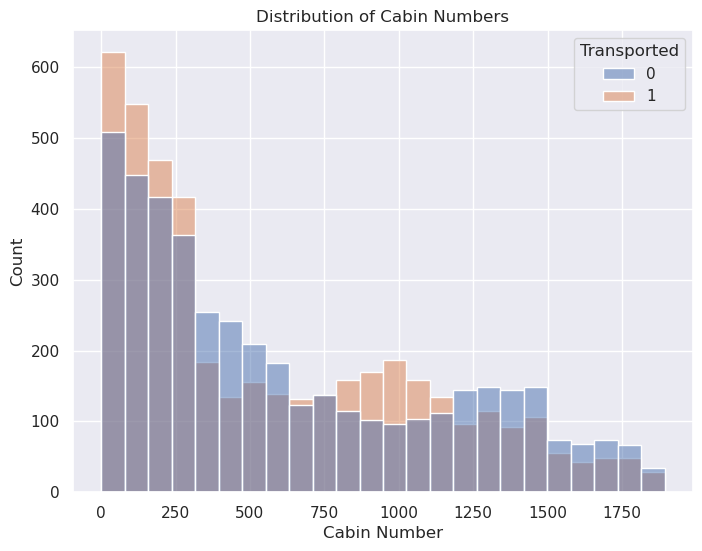

In [24]:
# Create a figure with a specified size
plt.figure(figsize=(8, 6))

# Plot a histogram of the 'Cabin_num' variable from the 'train' dataset,
# with different colors for the 'Transported' categories
sns.histplot(x=train['Cabin_num'], hue=train['Transported'])

# Set the title and axis labels for the plot
plt.title('Distribution of Cabin Numbers')
plt.xlabel('Cabin Number')
plt.ylabel('Count')

# Display the plot
plt.show()

## 4. **Feature Engineering**

In [25]:
def sum_bills(df):
    # Create a scaler object for later use
    scaler = StandardScaler()
    
    # Calculate the average of the 'FoodCourt' and 'ShoppingMall' columns and add to the dataframe as a new column
    df['good_places'] = df[['FoodCourt', 'ShoppingMall']].sum(axis=1)/2
    
    # Calculate the average of the 'RoomService', 'Spa', and 'VRDeck' columns and add to the dataframe as a new column
    df['terube_places'] = df[['RoomService', 'Spa', 'VRDeck']].sum(axis=1)/3
    
    # Scale the new columns using the StandardScaler
    # Uncomment the next two lines of code to scale the new columns
#     df['good_places'] = scaler.fit_transform(df['good_places'].values.reshape(-1, 1))
#     df['terube_places'] = scaler.fit_transform(df['terube_places'].values.reshape(-1, 1))
    
    # Return the modified dataframe
    return df

In [26]:
train = sum_bills(train)

In [27]:
def road(df):
    # Create a label encoder instance
    le = LabelEncoder()
    
    # Initialize an empty list to store road values
    res = []
    
    # Loop through the HomePlanet column and append the concatenated string of HomePlanet and Destination to the res list
    for ind, i in enumerate(df["HomePlanet"]):
        res.append(f'{i}-{df["Destination"][ind]}')
    
    # Create a new column 'road' in the dataframe and encode the concatenated string values using the label encoder
    df['road'] = res
    df['road'] = le.fit_transform(df['road'])
    
    # Return the updated dataframe with the new 'road' column
    return df

In [28]:
train = road(train)

## 5. **Modeling**

### **XGBoost**

In [29]:
# Get the column names of the training data
# and store them in a list called "columns"
columns = train.columns

In [30]:
# This line creates a list of features that will be used as input to a machine learning model.
features = ['CryoSleep', 'Age','good_places','terube_places','road', 'Deck', 'Cabin_num', 'Side']

# This line specifies the target variable, which is the variable we want to predict using the features.
target = 'Transported'

# This line creates two new variables: X, which contains the feature data, and y, which contains the target variable data.
# train is assumed to be a pandas DataFrame containing both the feature and target data.
X = train[features]
y = train[target]

In [31]:
# Split the dataset into training and testing sets with a 70-30 ratio and a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define an XGBoost classifier with some hyperparameters
xg = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, gamma=0.2)

# Create a pipeline with a StandardScaler and the XGBoost classifier
model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xg)
])

# Fit the pipeline to the training data
model.fit(X_train, y_train)

# Predict the labels of the test data using the fitted pipeline
y_pred = model.predict(X_test)

<BarContainer object of 8 artists>

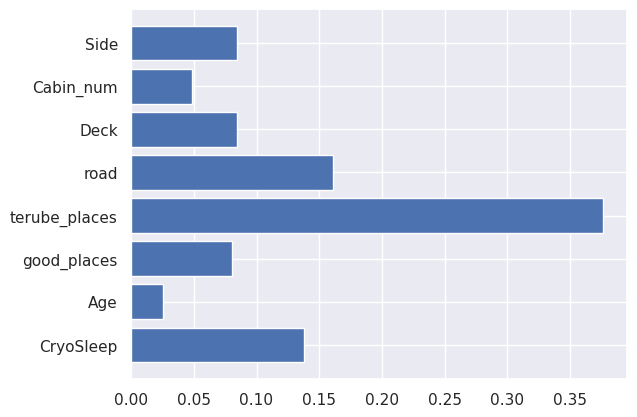

In [32]:
# Create a horizontal bar plot using Matplotlib's pyplot module
# The horizontal bar plot will display the feature importances for the XGBoost model
# The bar lengths will be determined by the feature importances, and the bars will be labeled with the corresponding feature names
plt.barh(X_train.columns, model['xgb'].feature_importances_)

In [33]:
# Creates a dictionary to store the metrics calculated below
metrics_dict = {
    'Accuracy': accuracy_score(y_test, y_pred),   # Calculates the accuracy score using y_test (true values) and y_pred (predicted values) and adds it to the dictionary
    'Precision': precision_score(y_test, y_pred), # Calculates the precision score using y_test and y_pred and adds it to the dictionary
    'Recall': recall_score(y_test, y_pred),       # Calculates the recall score using y_test and y_pred and adds it to the dictionary
    'F1': f1_score(y_test, y_pred),               # Calculates the F1 score using y_test and y_pred and adds it to the dictionary
    'ROC AUC': roc_auc_score(y_test, y_pred)      # Calculates the ROC AUC score using y_test and y_pred and adds it to the dictionary
}

# Returns the dictionary containing all the computed metrics
metrics_dict

{'Accuracy': 0.7933282208588958,
 'Precision': 0.773876404494382,
 'Recall': 0.8354814253222138,
 'F1': 0.8034998177178272,
 'ROC AUC': 0.7928376870598656}

### **CatBoost**

In [34]:
# This line creates a list of features that will be used as input to a machine learning model.
features = ['CryoSleep', 'Age','good_places','terube_places','road', 'Deck', 'Cabin_num', 'Side']

# This line specifies the target variable, which is the variable we want to predict using the features.
target = 'Transported'

# This line creates two new variables: X, which contains the feature data, and y, which contains the target variable data.
# train is assumed to be a pandas DataFrame containing both the feature and target data.
X = train[features]
y = train[target]

In [35]:
# Split the dataset into training and testing sets, with a 70-30 split and a random seed of 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Create a CatBoostClassifier model with 3000 iterations, using accuracy as the evaluation metric and with no verbosity
model = CatBoostClassifier(iterations=3000, eval_metric='Accuracy', verbose=0)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data using the trained model
y_pred = model.predict(X_test)

In [36]:
# Creates a dictionary to store the metrics calculated below
metrics_dict = {
    'Accuracy': accuracy_score(y_test, y_pred),   # Calculates the accuracy score using y_test (true values) and y_pred (predicted values) and adds it to the dictionary
    'Precision': precision_score(y_test, y_pred), # Calculates the precision score using y_test and y_pred and adds it to the dictionary
    'Recall': recall_score(y_test, y_pred),       # Calculates the recall score using y_test and y_pred and adds it to the dictionary
    'F1': f1_score(y_test, y_pred),               # Calculates the F1 score using y_test and y_pred and adds it to the dictionary
    'ROC AUC': roc_auc_score(y_test, y_pred)      # Calculates the ROC AUC score using y_test and y_pred and adds it to the dictionary
}

# Returns the dictionary containing all the computed metrics
metrics_dict

{'Accuracy': 0.8117331288343558,
 'Precision': 0.804860088365243,
 'Recall': 0.8286580742987112,
 'F1': 0.8165857302951064,
 'ROC AUC': 0.8115361744651042}

### **SVM**

In [37]:
# This line creates a list of features that will be used as input to a machine learning model.
features = ['CryoSleep', 'Age','good_places','terube_places','road', 'Deck', 'Cabin_num', 'Side']

# This line specifies the target variable, which is the variable we want to predict using the features.
target = 'Transported'

# This line creates two new variables: X, which contains the feature data, and y, which contains the target variable data.
# train is assumed to be a pandas DataFrame containing both the feature and target data.
X = train[features]
y = train[target]

In [38]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42 ,test_size=0.3)

# Creating a pipeline that first scales the data and then fits a Support Vector Machine (SVM) model
model = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the features by removing the mean and scaling to unit variance
    ('svm', SVC(C=5, probability=True))  # SVM model with regularization parameter C=5 and probability estimates enabled
])

# Training the model on the training data
model.fit(X_train, y_train)

# Making predictions on the testing data using the trained model
y_pred = model.predict(X_test)

In [39]:
# Creates a dictionary to store the metrics calculated below
metrics_dict = {
    'Accuracy': accuracy_score(y_test, y_pred),   # Calculates the accuracy score using y_test (true values) and y_pred (predicted values) and adds it to the dictionary
    'Precision': precision_score(y_test, y_pred), # Calculates the precision score using y_test and y_pred and adds it to the dictionary
    'Recall': recall_score(y_test, y_pred),       # Calculates the recall score using y_test and y_pred and adds it to the dictionary
    'F1': f1_score(y_test, y_pred),               # Calculates the F1 score using y_test and y_pred and adds it to the dictionary
    'ROC AUC': roc_auc_score(y_test, y_pred)      # Calculates the ROC AUC score using y_test and y_pred and adds it to the dictionary
}

# Returns the dictionary containing all the computed metrics
metrics_dict

{'Accuracy': 0.7921779141104295,
 'Precision': 0.7846153846153846,
 'Recall': 0.8119787717968158,
 'F1': 0.7980625931445604,
 'ROC AUC': 0.791947492958144}

### **Voting**

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Initialize an XGBoost classifier with some hyperparameters
xg = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, gamma=0.2)

# Initialize a CatBoost classifier with some hyperparameters
model1 = CatBoostClassifier(iterations=5000, eval_metric='Accuracy', verbose=0)

# Initialize a pipeline with StandardScaler and XGBoost
model2 = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xg)
])

# Initialize a pipeline with StandardScaler and Support Vector Machine (SVM)
model3 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=5, probability=True))
])

# Initialize a voting classifier with the three models as estimators
model = VotingClassifier(estimators=[('cat', model1), ('xg', model2), ('svm', model3)], voting='soft')

# Fit the voting classifier to the training data
model.fit(X_train, y_train)

# Use the fitted model to make predictions on the test data
y_pred = model.predict(X_test)

In [41]:
# Creates a dictionary to store the metrics calculated below
metrics_dict = {
    'Accuracy': accuracy_score(y_test, y_pred),   # Calculates the accuracy score using y_test (true values) and y_pred (predicted values) and adds it to the dictionary
    'Precision': precision_score(y_test, y_pred), # Calculates the precision score using y_test and y_pred and adds it to the dictionary
    'Recall': recall_score(y_test, y_pred),       # Calculates the recall score using y_test and y_pred and adds it to the dictionary
    'F1': f1_score(y_test, y_pred),               # Calculates the F1 score using y_test and y_pred and adds it to the dictionary
    'ROC AUC': roc_auc_score(y_test, y_pred)      # Calculates the ROC AUC score using y_test and y_pred and adds it to the dictionary
}

# Returns the dictionary containing all the computed metrics
metrics_dict

{'Accuracy': 0.8013803680981595,
 'Precision': 0.7883369330453563,
 'Recall': 0.8301743745261562,
 'F1': 0.8087149187592318,
 'ROC AUC': 0.8010452943228143}

## 6. **Sumbission**

In [42]:
# Clean the data in the test variable
test = clean(test)

# Calculate the total sum of bills in the cleaned test data
test = sum_bills(test)

# Process the road data in the test variable
test = road(test)

In [43]:
# make predictions on the test data using the trained model
sub_pred = model.predict(test[features])

# convert the continuous prediction values to binary (True/False) values based on a threshold of 0.5
sub_binary = [True if p >= 0.5 else False for p in sub_pred]

In [44]:
sample['Transported'] = sub_binary

In [45]:
sample['Transported'].value_counts()

True     2222
False    2055
Name: Transported, dtype: int64

In [46]:
# Export the 'sample' DataFrame to a CSV file named 'submission.csv' without including the index column.
sample.to_csv('submission.csv', index=False)

# **Thank You !**